# UK Covid-19 Analysis

## Downloading the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
#df_recovered = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

def get_uk_data(df, name):
    df_uk_all = df.loc[df['Country/Region'] == "United Kingdom"]
    df_uk = df_uk_all[df_uk_all['Province/State'].isnull()]
    df_uk = df_uk.drop(df_uk.columns[[0, 1, 2, 3]], axis=1)
    df_uk_t = df_uk.T
    df_uk_t.columns = [name]
    return df_uk_t

df_confirmed_uk = get_uk_data(df_confirmed, "Confirmed Cases")
df_deaths_uk = get_uk_data(df_deaths, "Deaths")

df_uk = pd.concat([df_confirmed_uk, df_deaths_uk], axis=1, sort=False)
df_uk["Date"] = list(df_confirmed_uk.index.values)

df_uk['Date'] = pd.to_datetime(df_uk['Date'], format="%m/%d/%y")
df_uk = df_uk.sort_values(by='Date')

## Initial plots
### Standard plot

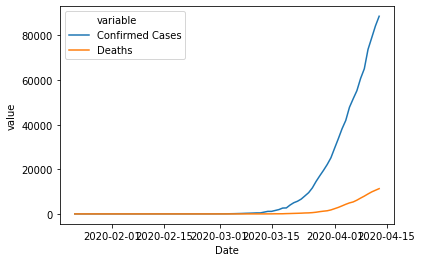

In [2]:
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df_uk, ['Date']))

### Logarithmic plots

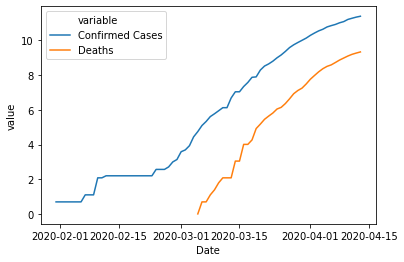

In [3]:
df_uk_log = pd.concat([df_uk["Date"], df_uk[["Confirmed Cases", "Deaths"]].apply(np.log)], axis=1, sort=False)
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(df_uk_log, ['Date']))

### New Cases

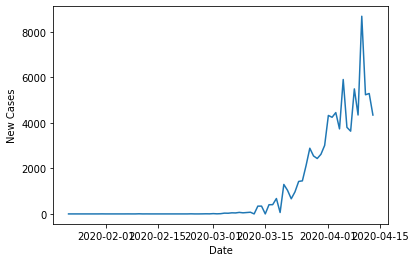

In [4]:
df_new_cases = pd.concat([df_uk["Confirmed Cases"], df_uk["Confirmed Cases"].shift(1)], axis=1, sort=False, keys=["cases", "shifted"])
df_new_cases = df_new_cases.fillna(0)

df_new_cases["new"] = df_new_cases["cases"] - df_new_cases["shifted"]

df_uk["New Cases"] = df_new_cases["new"]

sns.lineplot(x='Date', y='New Cases', data=df_uk)

### Existing vs Total

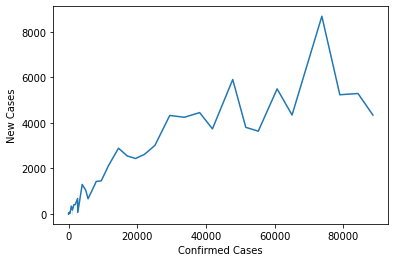

In [5]:
sns.lineplot(x='Confirmed Cases', y='New Cases', data=df_uk)

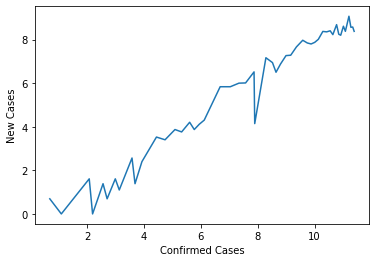

In [6]:
df_new_existing_log = df_uk[["Confirmed Cases", "New Cases"]].apply(np.log)

df_new_existing_log = df_new_existing_log.replace([np.inf, -np.inf], np.nan)
df_new_existing_log = df_new_existing_log.dropna()

sns.lineplot(x='Confirmed Cases', y='New Cases', data=df_new_existing_log)

## UK Key Dates

In [7]:
lockdown_date = "2020-03-23"
delay_phase_date = "2020-03-05"

## Regression Analysis

In [8]:
from sklearn.linear_model import LinearRegression

# need to have a continuous X so we will add column of number of days past

df_uk_log = df_uk_log.reset_index()
df_uk_log["Days Past"] = df_uk_log.index

# need to remove -inf values

df_uk_log = df_uk_log.replace([np.inf, -np.inf], np.nan)
df_uk_log = df_uk_log.dropna()

print(df_uk_log.head(5))

     index       Date  Confirmed Cases    Deaths  Days Past
43  3/5/20 2020-03-05         4.744932  0.000000         43
44  3/6/20 2020-03-06         5.093750  0.693147         44
45  3/7/20 2020-03-07         5.327876  0.693147         45
46  3/8/20 2020-03-08         5.609472  1.098612         46
47  3/9/20 2020-03-09         5.771441  1.386294         47


In [9]:
# now we can regress

X = np.array(df_uk_log["Days Past"]).reshape(-1,1)
y = np.array(df_uk_log["Confirmed Cases"]).reshape(-1,1)

cases_reg = LinearRegression().fit(X, y)

m = cases_reg.coef_[0][0]
b = cases_reg.intercept_[0]

print("Cases Coefficient: " + str(m))
print("Cases Intercept: " + str(b))

Cases Coefficient: 0.173969593268338
Cases Intercept: -2.1459329024650344


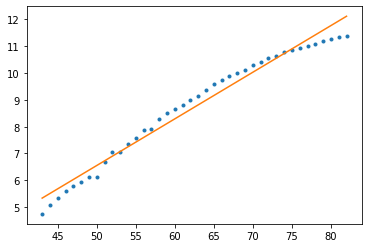

In [10]:
plt.plot(X, y, '.')

y = m*X + b

plt.plot(X, y, '-')
plt.show()

In [11]:
cases_doubling_time = np.log(2)/m
print("Cases double every %.1f days" % cases_doubling_time)

Cases double every 4.0 days


In [12]:
# now we can regress

X = np.array(df_uk_log["Days Past"]).reshape(-1,1)
y = np.array(df_uk_log["Deaths"]).reshape(-1,1)

deaths_reg = LinearRegression().fit(X, y)

m = deaths_reg.coef_[0][0]
b = deaths_reg.intercept_[0]

print("Cases Coefficient: " + str(m))
print("Cases Intercept: " + str(b))

Cases Coefficient: 0.24477527682949932
Cases Intercept: -9.695937623042726


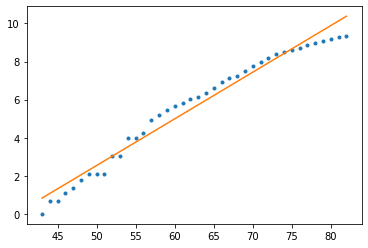

In [13]:
plt.plot(X, y, '.')

y = m*X + b

plt.plot(X, y, '-')
plt.show()

In [14]:
deaths_doubling_time = np.log(2)/m
print("Deaths double every %.1f days" % deaths_doubling_time)

Deaths double every 2.8 days


## Simulations with SIR

For number of cases N(t), growth rate K is
K = d(ln(N))/dt .

Then
